<a href="https://colab.research.google.com/github/Rin-Sanity/test1/blob/main/NeRelation_graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# テキスト分割し、LLMに入力するプロンプトを作成するコード

In [1]:
def split_text(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()
    lines = [line.rstrip('\n') for line in lines]
    #問題
    question = lines[0] + '\n' + lines[1]
    #選択肢
    choices = lines[2:6]
    #問題+選択肢
    pairs = [question + '\n' + choice for choice in choices]
    return pairs

def create_prompt(pairs):
    prompt_template = """
# タスク
例文を参考に、入力文から固有表現と固有表現間の関係を抽出してください

# 条件
・固有表現は人名(People)、不動産(Property)の二つとする
・「人名(People)」は、具体的な人名に加え、代理人、相手方、第三者などの役割を持つ人物も含める
・関係は必ず次のものから選択すること
所有(人,不動産),
賃貸(人,人),
転貸(人,人),
媒介(人,人),
代理(人,人),
復代理(人,人),
抵当権設定(人,人),
占有(人,不動産),
登記(人,不動産),
通謀(人,人),
債権債務(人,人),
相続(人,人),
譲渡(人,人),
不法行為(人,人)

# 入力文
入力:
「{}」

# 出力形式
1.タグ付けされた文:{{固有表現をタグ付けした文}}
2.関係抽出:{{固有表現間の関係}}

# 例
入力例1:
入力文:{{Aが所有する甲建物をBに売却し、BがCに賃貸した。}}
出力文:{{<People>A</People>が所有する<Property>甲建物</Property>を<People>B</People>に売却し、<People>B</People>が<People>C</People>に<Property>甲建物</Property>を賃貸した。}}
関係:
所有(A,甲建物)
譲渡(A,B)
賃貸(B,C)

入力例2:
入力文:{{乙土地の所有者が乙土地をEに譲渡し、EがFに乙土地を賃貸した。}}
出力文:{{<People>所有者</People>が所有する<Property>乙土地</Property>を<People>E</People>に譲渡し、<People>E</People>が<People>F</People>に<Property>乙土地</Property>を賃貸した。}}
関係:
所有(所有者,乙土地)
譲渡(D,E)
賃貸(E,F)}}
"""

    prompts = []#プロンプトのリスト
    for pair in pairs:
        prompts.append(prompt_template.format(pair))#{}にペアを挿入
    return prompts

text_file = '2001_1.txt'
pairs = split_text(text_file)
few_shot_prompts = create_prompt(pairs)


for prompt in few_shot_prompts:
    print(prompt,'\n')



# タスク
例文を参考に、入力文から固有表現と固有表現間の関係を抽出してください

# 条件
・固有表現は人名(People)、不動産(Property)の二つとする
・「人名(People)」は、具体的な人名に加え、代理人、相手方、第三者などの役割を持つ人物も含める
・関係は必ず次のものから選択すること
所有(人,不動産),
賃貸(人,人),
転貸(人,人),
媒介(人,人),
代理(人,人),
復代理(人,人),
抵当権設定(人,人),
占有(人,不動産),
登記(人,不動産),
通謀(人,人),
債権債務(人,人),
相続(人,人),
譲渡(人,人),
不法行為(人,人)

# 入力文
入力:
「#Q1
A・B・Cが、持分を6・2・2の割合とする建物の共有をしている場合に関する次の記述のうち、民法の規定及び判例によれば、正しいものはどれか。
#C1:Aが、B・Cに無断で、この建物を自己の所有としてDに売却した場合は、その売買契約は有効であるが、B・Cの持分については、他人の権利の売買となる。」

# 出力形式
1.タグ付けされた文:{固有表現をタグ付けした文}
2.関係抽出:{固有表現間の関係}

# 例
入力例1:
入力文:{Aが所有する甲建物をBに売却し、BがCに賃貸した。}
出力文:{<People>A</People>が所有する<Property>甲建物</Property>を<People>B</People>に売却し、<People>B</People>が<People>C</People>に<Property>甲建物</Property>を賃貸した。}
関係:
所有(A,甲建物)
譲渡(A,B)
賃貸(B,C)

入力例2:
入力文:{乙土地の所有者が乙土地をEに譲渡し、EがFに乙土地を賃貸した。}
出力文:{<People>所有者</People>が所有する<Property>乙土地</Property>を<People>E</People>に譲渡し、<People>E</People>が<People>F</People>に<Property>乙土地</Property>を賃貸した。}
関係:
所有(所有者,乙土地)
譲渡(D,E)
賃貸(E,F)}
 


# タスク
例文を参考に、入力文から固有表現と固有表現間の関係を抽出してください


# LLMからの出力からエンティティと関係を抜き出し、グラフ出力するコード

In [2]:
!apt-get update
!apt-get install fonts-ipafont-gothic
import re
from graphviz import Digraph
from IPython.display import Image, display

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:5 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Ign:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy Release [5,713 B]
Get:9 https://r2u.stat.illinois.edu/ubuntu jammy Release.gpg [793 B]
Hit:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:12 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,071 kB]
Hit:13 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
G

NE_text:

<People>A</People>・<People>B</People>・<People>C</People>が、持分を6・2・2の割合とする<Property>建物</Property>の共有をしている場合に関する次の記述のうち、民法の規定及び判例によれば、正しいものはどれか。裁判による共有物の分割では、<People>A</People>に<Property>建物</Property>を取得させ、<People>A</People>から<People>B</People>・<People>C</People>に対して適正価格で賠償させる方法によることは許されない。


RE_text:

共有(A, 建物)
共有(B, 建物)
共有(C, 建物)
債権債務(A, B)
債権債務(A, C)

['A', 'B', 'C', 'A', 'A', 'B', 'C']
['建物', '建物']
People: {'B', 'A', 'C'}
Properties: {'建物'}
Nodes: {'B': 'B', 'A': 'A', 'C': 'C', '建物': '建物'}
1: 共有
2: A, 建物
1: 共有
2: B, 建物
1: 共有
2: C, 建物
1: 債権債務
2: A, B
1: 債権債務
2: A, C


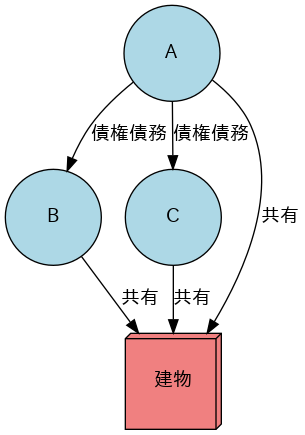

In [3]:
def ne_re_extract_make_graph(NE_text, RE_text, font_name='IPAPGothic'):
    #ne_reの抽出
    people = re.findall('<People>(.*?)</People>', NE_text)
    properties = re.findall('<Property>(.*?)</Property>', NE_text)
    print(people)
    print(properties)

    #set()で重複削除
    people_set = set(people)
    property_set = set(properties)
    print("People:",people_set)
    print("Properties:",property_set)

    dot = Digraph(format='png', encoding='utf-8')

    #perとpropのノード追加
    node_dict = {}
    for per in people_set:
        dot.node(per,
                 label=per,
                 shape='circle',
                 style='filled',
                 fillcolor='lightblue',
                 fontname=font_name,
                 width='1', height='1', fixedsize='true')
        node_dict[per] = per

    for prop in property_set:
        dot.node(prop,
                 label=prop,
                 shape='box3d',
                 style='filled',
                 fillcolor='lightcoral',
                 fontname=font_name,
                 width='1', height='1', fixedsize='true')
        node_dict[prop] = prop
    print("Nodes:", node_dict)

    #RE_textから前後の空白を削除、改行で分割して各行を処理
    lines = RE_text.strip().split('\n')
    for line in lines:
        #行が'関係名(エンティティ1, エンティティ2)'にマッチするか正規表現でチェックしてグループ化
        match = re.match(r'(\w+)\((.+?)\)', line)
        if match:
            print("1:",match.group(1))
            print("2:",match.group(2))
            #マッチした場合、関係の種類を取得（括弧の前の単語）
            relation_type = match.group(1)
            #かっこ内のエンティティをカンマで分割、各エンティティの前後の空白を削除
            entities = [e.strip() for e in match.group(2).split(',')]
            start,end = entities
            #dictからノード名を取得し、エッジ追加(この処理で同じノードが追加された時の重複を防ぐ)
            dot.edge(
                #グラフにエッジを追加（スタートからエンドに）
                node_dict.get(start,start),
                node_dict.get(end,end),
                label=relation_type,
                fontname=font_name
            )

    #pngとして図を出力
    dot.render('output1', format='png', view=True)
    display(Image(filename='output1.png'))


#APIから得られる出力
api_output = """
1. タグ付けされた文: {<People>A</People>・<People>B</People>・<People>C</People>が、持分を6・2・2の割合とする<Property>建物</Property>の共有をしている場合に関する次の記述のうち、民法の規定及び判例によれば、正しいものはどれか。裁判による共有物の分割では、<People>A</People>に<Property>建物</Property>を取得させ、<People>A</People>から<People>B</People>・<People>C</People>に対して適正価格で賠償させる方法によることは許されない。}

2. 関係抽出: 共有(A, 建物), 共有(B, 建物), 共有(C, 建物), 債権債務(A, B), 債権債務(A, C)
"""

#APIの出力形式が分かったら追加予定
  #NE_textの抽出（{ } 内の内容を抽出）
  #RE_textの抽出（: の後の内容を抽出し、カンマ区切りを改行に変換）

NE_text = """
<People>A</People>・<People>B</People>・<People>C</People>が、持分を6・2・2の割合とする<Property>建物</Property>の共有をしている場合に関する次の記述のうち、民法の規定及び判例によれば、正しいものはどれか。裁判による共有物の分割では、<People>A</People>に<Property>建物</Property>を取得させ、<People>A</People>から<People>B</People>・<People>C</People>に対して適正価格で賠償させる方法によることは許されない。
"""

RE_text = """
共有(A, 建物)
共有(B, 建物)
共有(C, 建物)
債権債務(A, B)
債権債務(A, C)
"""


print("NE_text:")
print(NE_text)
print("\nRE_text:")
print(RE_text)

ne_re_extract_make_graph(NE_text, RE_text)
